In [1766]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfTransformer,CountVectorizer
from nltk.corpus import stopwords
import regex as re
import requests
from logging import raiseExceptions
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import contractions
import nltk
from scipy import stats

import time
import spacy
import spacy.cli

pd.set_option('max_colwidth', 400)

# Data Collection

##### Get Submissions method

In [877]:
def get_submission(theme, requests_amount):
    list_submission=[]
    counter=0
    sum=0
    for x in range(1,requests_amount+1):
        url_topic_1=f"https://api.pushshift.io/reddit/search/submission/?subreddit={theme}&fields=selftext,removed_by_category&size=100&before={counter}d"
        req_1=requests.get(url_topic_1)
        #to avoid overrequesting API, code is waiting for a second after request
        time.sleep(1)

        if req_1.status_code==200:
            counter+=1
            sq=req_1.json()            
            for x in sq["data"]:
                #I am checking "removed by category" field, to exclude spam and inappropriate posts, deleted by bot.
                if "removed_by_category" not in x:
                    list_submission.append(x["selftext"])
                    sum+=1                
        else:
            print(f"There was a mistake {req_1.status_code}")
            return list_submission
    print(f"{sum} submissions downloaded")       
    return list_submission

##### Get commentaries method

In [1086]:
#processing url and getting list of comments

def get_comment(theme,quant):
    list_comments=[]
    counter=0
    for x in range(1,36,2):
        url_topic_1=f"https://api.pushshift.io/reddit/search/comment/?size={quant}&subreddit={theme}&before={x}d"
        req_1=requests.get(url_topic_1)
        if counter%2==0:
            #Waiting for a second each 2nd request
            time.sleep(1)
        if req_1.status_code==200:
            counter+=1
            sq=req_1.json()            
            for x in sq["data"]:
                list_comments.append(x['body'])                
        else:
            return f"Code was {req_1.status_code}"
    return list_comments

##### Cleaning with RegExp

In [1869]:
#using regexp to clean recieved comments
def clean(sq):
    sq=[x.lower() for x in sq if x.find("Your submission has been")==-1] #drops posts of antispam bot
    sq=[x.lower() for x in sq if x!="delete"] # drops posts with "delete" in them
    sq=[x.lower() for x in sq if x.find("title")==-1] 
    sq=[re.sub("(https?:\/\/)?([\da-z\.-]+)\.([a-z\.]{2,6})([\/\w \.-]*)"," ", x.lower()) for x in sq] #drops all links
    sq=[re.sub("(.)\1{2}"," ", x.lower()) for x in sq] # drops all words where 3 or more same letters are put together like "aaaaand", "soooooo"
    sq=[re.sub("\W+"," ", x.lower()) for x in sq] #drops all whitespace symbols like \n \t etc.
    sq=[re.sub("\w*\d\w*"," ", x.lower()) for x in sq] #drops all words with numbers in them 
    sq=[re.sub("\s[a-z]{1,2}\s"," ", x.lower()) for x in sq] #drops all two letter words, because almost all of them are Stop-words
    sq=[re.sub("\s[a-z]{1,1}\s"," ", x.lower()) for x in sq] #drops all one letter words,for some reason previous regex left some of those
    sq=[re.sub("^i+(?!$)"," ", x.lower()) for x in sq] #drops fist letter if it is i
    sq=[x.lower().strip() for x in sq if x.find("removed")==-1] #drops "removed" comments, sent by api 
    sq=[re.sub("^m+(?!$)"," ", x.lower()) for x in sq] #drops fist letter if it is m
    sq=set(sq) #Leaving only unique values

    
    return sq


#### Downloading and cleaning commentaries

In [1088]:
AskMan_comment=get_comment("AskMen",130)
len(set(AskMan_comment))

2183

In [1089]:
AskWoman_comment=get_comment("AskWomen",130)
len(set(AskWoman_comment))

2096

##### Adding columns for classification and saving dataset

In [1104]:
AskMan_comment=clean(set(AskMan_comment))
AskMan_comment_df=pd.DataFrame(AskMan_comment)
AskMan_comment_df['sex']=1
AskMan_comment_df.columns=["comment",'sex']

AskWoman_comment=clean(set(AskWoman_comment))
AskWoman_comment_df=pd.DataFrame(AskWoman_comment)
AskWoman_comment_df['sex']=0
AskWoman_comment_df.columns=["comment",'sex']

AskMan_comment_df.shape, AskWoman_comment_df.shape

In [ ]:
final_comment_df=pd.concat([AskMan_comment_df,AskWoman_comment_df])
final_comment_df.reset_index(inplace=True,drop=True)
final_comment_df

final_comment_df.to_csv('../data/df_comments.csv',index=False)

----

#### Downloading Submissions

In [839]:
AskMan=get_submission("AskMen",130)


5335 submissions downloaded


In [840]:
len(set(AskMan))

2682

In [842]:
AskWoman=get_submission("AskWomen",130)
len(set(AskWoman))


5665 submissions downloaded


2080

In [1870]:
c_ask_man=clean(AskMan)
c_ask_woman=clean(AskWoman)
print(f"Unique AskMan comments:  {len(c_ask_man)}")
print(f"Unique AskWoman comments: {len(c_ask_woman)}")

Unique AskMan comments:  2599
Unique AskWoman comments: 2017


##### Adding target column for future classification

In [1871]:
df_cleaned_man=pd.DataFrame(data=c_ask_man)
df_cleaned_man["sex"]=1
df_cleaned_man.columns = ["comment","sex"]
df_cleaned_man=df_cleaned_man[df_cleaned_man["comment"]!=""]
df_cleaned_man


,comment,sex
1,every time tried get into relationship become disinterested the last second,1
2,have big crush her and she has boyfriend have one hand holding so afraid she gonna see what,1
3,with men that manipulate and gaslight girl what are your core intentions you even like the girl going through all that why can you just leave her alone are you even aware doing thanks,1
4,real examples hey council pick is friday will you home help move the bed frame the sidewalk not ll have switch shift also dinner plans steak pasta at the shops now male housemate steak sounds good sends meme first hey ll there when you clock off work also idk we should still invite given what happened tuesday might awks have friend amp ironed things out male friend haha sends meme back...,1
5,ok this situation happens lot where you are sitting with your friend and his friend and then friend leaves and now you both are just sitting there and one talking and just very awkward,1
...,...,...
2594,so for context ve been an off and relationship for very long time during all off times both were single broke all off our relationship and friendship like about half year ago and took like solid months get over her lately ve been feeling that miss her but pretty sure don really miss her more than that just miss the idea us and being relationship and love hope everything ve just said makes ...,1
2595,guy who had drinks some ocassion past relatives would ask to drink eventhough was just kid know that immoral anyways also that time used think cool after that used drink from dad bottle that used hide like once year and didn taste good all used drink feel intoxicated fast forward present drink again from his bottle yesterday and found still don like taste all hence ve always wondered that pe...,1
2596,let say you physically remain the same you are now and won age you live the age what would you within that time the average person lives the age and seems never has time do all the things one wants do however you could live for the next years what sort things would you,1
2597,probably bought over through the years where the heck they all,1


In [1872]:
df_cleaned_woman=pd.DataFrame(data=c_ask_woman)
df_cleaned_woman["sex"]="0"
df_cleaned_woman.columns = ["comment","sex"]
df_cleaned_woman=df_cleaned_woman[df_cleaned_woman["comment"]!=""]
df_cleaned_woman

,comment,sex
1,watching the rise skywalker tv wife said star wars guy thing and women don like said there are lot women that like,0
2,nterested send message looking for sine one quick,0
3,hello new here and would like make new friends and just have conversations ️ ️,0
4,something the heart your identity maybe quiet secret you wish someone else could recognize for what is show yourself some love and self appreciation today,0
5,ok my daughter having sleep over this weekend she asked to buy the facemasks facials that always get her she wants do them with the girls heres the problem they are the charcoal masks its say yes tomatoes charcoal mask she likes them because they peel off and its cool initially thought was problem but with how things are nowadays don know are very pale blondes and most the girls are white ...,0
...,...,...
2012,have you ever encountered any issues,0
2013,what you think about the thing where the person holds your face between their hands when they kiss you this supposed be super hot super romantic whatever just wondering what every one thinks,0
2014,usually just listen some music watch movie,0
2015,comment your to hookup outfits,0


##### Concatenating final united dataframe

In [1873]:
final_df=pd.concat([df_cleaned_man[:2056],df_cleaned_woman[:]],ignore_index=True)

In [1874]:
final_df.shape

(4072, 2)

In [1875]:
final_df.head()

,comment,sex
0,every time tried get into relationship become disinterested the last second,1
1,have big crush her and she has boyfriend have one hand holding so afraid she gonna see what,1
2,with men that manipulate and gaslight girl what are your core intentions you even like the girl going through all that why can you just leave her alone are you even aware doing thanks,1
3,real examples hey council pick is friday will you home help move the bed frame the sidewalk not ll have switch shift also dinner plans steak pasta at the shops now male housemate steak sounds good sends meme first hey ll there when you clock off work also idk we should still invite given what happened tuesday might awks have friend amp ironed things out male friend haha sends meme back...,1
4,ok this situation happens lot where you are sitting with your friend and his friend and then friend leaves and now you both are just sitting there and one talking and just very awkward,1


##### Checking for nulls and column types

In [1876]:
final_df.isnull().sum()

comment    0
sex        0
dtype: int64

In [1877]:
final_df.dtypes

comment    object
sex        object
dtype: object

"Sex" column is binary and should be int.

In [1878]:
final_df["sex"]=final_df["sex"].astype(int)
final_df.dtypes

comment    object
sex         int64
dtype: object

In [1879]:
#saving file
final_df.to_csv("../data/df_submissions_reserv.csv",index=False)

----

# EDA and Cleaning

##### Expanding Contractions

In [1880]:
def expand(document):
    result=""
    for word in document.split(" "):        
        result+=contractions.fix(word)
        result+=" "
    return result.strip()

In [1881]:
final_df['comment']=final_df['comment'].apply(lambda x: expand(x))

#### Processing with SpaCy 

(I didn't use pipelines, because I've used stages for modeling)

In [ ]:
spacy.cli.download('en_core_web_md')
nlp = spacy.load('en_core_web_md')

Lemmatizing each word and dropping auxilary words

In [1882]:
def drop_aux(docs):
    cleaned=""
    nlp_doc=nlp(docs)
    for word in nlp_doc:
        if word.pos_!="AUX":
            cleaned+=str(word.lemma_)
            cleaned+=" "
    return cleaned.strip()


In [1883]:
final_df['comment']=final_df["comment"].apply(lambda x: drop_aux(x))
#Dropping all possible empty rows, which contained only aux
final_df=final_df[final_df["comment"]!=""]

----

##### Compairing submissions method

after modeling find most useful posts and compare submissions with those words. Find best words.

In [ ]:

df_comparing=pd.DataFrame(columns=["mcomment","wcomment","score"])
df_comparing
for mcomment in df_cleaned_man["comment"]:
    for wcomment in df_cleaned_woman["comment"]:
        mnlp=nlp(mcomment)
        wnlp=nlp(wcomment)
        score=mnlp.similarity(wnlp)
        if score>0.9:
            print (mcomment, wcomment)
        # temp={"mcomment":mcomment,"wcomment":wcomment,"score":score}
        # df_comparing.append(temp,ignore_index=True)

##### Check for Sentiment Scores

In [1884]:
sent= SentimentIntensityAnalyzer()

AskMan submissions

In [1885]:
result=[]
for mcomment in df_cleaned_man["comment"]:    
    score=sent.polarity_scores(mcomment)
    temp={"comment":mcomment,"score":score["compound"]}
    result.append(temp)
    # df_man_sentiment.append(temp,ignore_index=True)
df_man_sentiment=pd.DataFrame(data=result)

df_man_sentiment.sort_values(by=["score"],ascending=False)

,comment,score
85,worried that will just deny because feels ashamed thinks might lose this isn the case be honest don have issue he wants sleep with other girls understand some people are just like that and want him be happy used have issue with as lied me when found out was hitting this other woman while said wanted to exclusive but don anymore do however have issue with dishonesty also portrayed lot things ...,0.9988
1597,a couple months ago one my friends ll call her tayla that in long term relationship mentioned one her guy friends will call him will she grew with single and her and her partner wanted set up with him she showed photo but said said slept with another one our friends within the group ll call her jess back when they were high school high school was good years ago for but was still uninterested...,0.9986
2554,go first before start off the new year years old and one the things want out life to make least in job love do either marketing business tech the next thing want lovely wife who also career driven amazing loyal supportive and god fearing doesn matter me how much money she makes but just want lovely wife want own beautiful huge log cabin house share with wife want have pets own weapons an...,0.9982
1205,so uni the group people talking about all living dorms campus re great group friends closest friends are guy and girl who somewhat interested but being the less funny less attractive less interesting person she would not interested me back accepted the fate friendship which isn too bad itself but the guy has been interested her for quite some time and actively trying persue something out i...,0.9981
1153,hi bad putting what think text but ll try best basically heard guy tiktok say that men put women into one three categories the romantic type the sexual type and the rare friend type the romantic type basically someone they could see themselves genuinely loving and having romantic relationship with and maybe more one day the sexual type someone they see only good for sex sexual favors and the f...,0.9977
...,...,...
125,scenario you just got home after work and around midnight you tired but suddenly you hear your daughter son scream for help louder than you ever thought possible and you run their bedroom where they should have been asleep but the time you get there they are dead the murderer standing above them holding the murder weapon you happen be holding gun how you react for extra context you know for fa...,-0.9870
818,hi men reddit over the last year ve been making conscious effort become assertive after many years poor treatment from various people my life ve taken boxing practiced stronger eye contact been quicker make complaints about bad service etc ve long way go but slowly feel myself becoming less pushover and think people general have been little nicer me maybe carrying myself differently dunno but ...,-0.9900
482,oh boy here go maybe some background about will help was raised my single mother alongside two elder sisters didn have necessarily bad relationship with father growing we just weren close matter how much mother tried have spend time together when got my late teens decided would stop seeing him and putting the effort because never reached out me and never seemed care that much but like said the...,-0.9929
1096,have reason be shitting myself but can sleep anymore just workout exhaustion but still every night when fall my bed fell this horrible fear afraid suffering violence some hipotical injustice some lovedones suffering am mess for reason this happening frequently for almost years but have memories being teenager and just whacthing on because was afraid try talk my girlfriend but she didn unders...,-0.9936


Plotting AskMan submission scores

<Figure size 432x288 with 0 Axes>

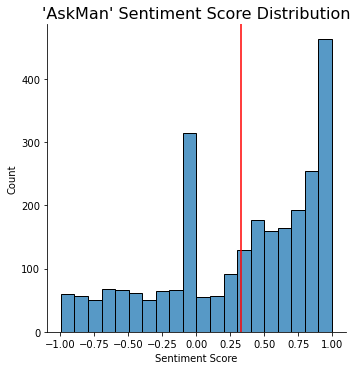

In [1886]:
plt.tight_layout()
sns.displot(df_man_sentiment.score, bins=20)
plt.xlabel("Sentiment Score", size=10)
plt.ylabel("Count", size=10)
plt.axvline(x=df_man_sentiment.score.mean(),
            color='red')
plt.title("'AskMan' Sentiment Score Distribution", size = 16)
plt.savefig('../resources/AskWomanSantiment.png')


AskWoman submissions

In [1887]:
result=[]

for wcomment in df_cleaned_woman["comment"]:    
    score=sent.polarity_scores(wcomment)
    temp={"comment":wcomment,"score":score["compound"]}
    result.append(temp)
df_woman_sentiment=pd.DataFrame(result)
df_woman_sentiment.sort_values(by="score",ascending=False)

,comment,score
1216,so this friend will call her old friend and have known each other since were grade even though didn really talk much until the start high school now re university different university btw she and this other friend were the two people mostly talked throughout high school met another friend will call her the new friend my last year high school and after few years knowing her she asked for numb...,0.9994
144,really random thought here but was just wondering young woman myself and just find that girls can extremely rude and aggressive towards one another and not only that but also fake have few good friends that are women they are cool and love them but sometimes their about them attitudes can so nasty for reason asked one them simple question and she got irritated and nastywith that other frie...,0.9987
1432,this got bit long but feel the details are important couple weeks ago this girl matched with tinder she was cute but not your stereotypical beauty someone that was definitely my league she immediately commented how cute was one my photos and after few texts she asked to hang out later that night worked early we didn end hanging out but exchanged handful more texts that night and the next m...,0.9986
45,this got bit long but feel the details are important couple weeks ago this girl matched with tinder she was cute but not your stereotypical beauty someone that was definitely my league she immediately commented how cute was one my photos and after few texts she asked to hang out later that night worked early we didn end hanging out but exchanged handful more texts that night and the next m...,0.9985
1935,for context friend and have been best friends since grade am now married husband friend visiting from florida month after moved california re still settling but thought would good idea come for his which the time thought would too aslong had job well got that job and not the kind job can just call off willy nilly just request off whenever tried express that since was new job wasn gon...,0.9979
...,...,...
1678,hi hope writing this the right place was reading some red flag for relationships earlier and wanted know my last relationship made toxic was just ex met bf which was november was very sweet and approached in different way than most boys so that caught he spoke about spiritually manifestation and love languages which was something was interested lot during healing journey losing dad also ...,-0.9897
533,when have sex all she wanted was for to fuck her and that it wouldn let finger her anything else literally just kiss and fuck was honestly the worst sex ever had effort was one sided but because liked her and ignored all needs were not met once through out the short relationship she would odd things like say fuck here were outside and course was that but then seconds later bring something ...,-0.9899
1307,to brother thanks for being home early and showering normally have very short min time frame every weekday when home alone perfect time frame quickly shower put clean hygiene product and throw away the waste the garbage can outside without someone hovering over it was plan had been plan all day didn want step outside room and have mother me questioning every move and watching like hawk but y...,-0.9928
322,does anyone else just get sick being around your partner family feel terrible for saying this but just wanted unbiased opinion his family are big socializers his several aunties and mum drink regularly together and see each other every weekend don get wrong love close family bonds but when they start drinking they start talking shit about everyone and even between themselves is almost contest ...,-0.9949


Plotting AskWoman submission scores

<Figure size 432x288 with 0 Axes>

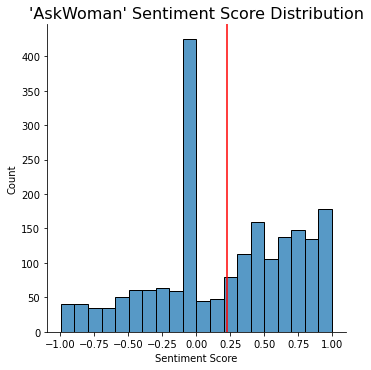

In [1888]:
plt.tight_layout()
sns.displot(df_woman_sentiment.score, bins=20)
plt.xlabel("Sentiment Score", size=10)
plt.ylabel("Count", size=10)
plt.axvline(x=df_woman_sentiment.score.mean(),
            color='red')
plt.title("'AskWoman' Sentiment Score Distribution", size = 16)
plt.savefig('../resources/AskWomanSantiment.png')


----

##### Check for outliers

/Users/glebradchenko/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


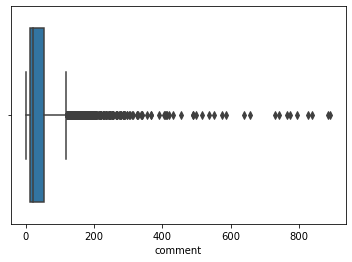

In [1889]:

plt.tight_layout()
sns.boxplot(final_df['comment'].str.split(" ").str.len())
plt.savefig('../resources/BoxPlot.png')

There are 72 rows with text length more than 3 standart deviations. Concidering, that these values occured not because of the technical error I'll keep them.

In [1890]:
final_df[(np.abs(stats.zscore(final_df["comment"].str.len())) > 3)]


,comment,sex
81,over here canada have some restriction currently place that shut down lot social place our restaurant take out only right now and bar completely close use occasionally to the club and social when have the opportunity but even then people restrict their table and really hinder the social part not currently school right now don have that social aspect my life meet people and interact understand ...,1
85,worry that just deny because feel ashamed think lose this isn the case honest don have issue he want sleep with other girl understand some people just like that and want he happy use have issue with as lie I when find out hit this other woman while say want to exclusive but don anymore however have issue with dishonesty also portray lot thing differently the begin our relationship like how str...,1
208,so just get out year relationship not too long ago about over month and the break come for awhile only couple day later the person have lot history he in ex coworker and use just have casual sex texte we then few night later have sex and pick up and intention sleepover his apartment cuddle which never happen before and watch netflix the next morning and take home nothing much happen a...,1
246,hey guy year old man here my final year university date for the past year and leave disillusioned and weary really lose interest it because haven make much headway after year all friend this point seem atleast one two relationship under their belt just feel like miss out the most fun year my life term date and sex and hard not feel negative and angry about we in our prime our and g...,1
275,so the composition class for around week now the end the semester near and theirs this really cute girl hard core crushing tell myself wasn go talk she and out my way but just keep think about her wasn till have dream about she that decide need get her number get her number friday where out the normal classroom and the computer lab sit right next she and start the conversation off with how ...,1
...,...,...
3816,tldr lot movie and show have unnecessary scene especially write man and just wonder how you guy feel about the story author when you see these thing especially when do frequently in perverse way long version for abhor pe scene especially they unnecessary frequent and have purpose sometimes even loathe own gender when watch scene where the scene make out sexy with show try show the sex part it ...,0
3843,english not first language ex and meet university re study together now re from latin america she an instagram model didn have social medium she make one from day one meet school click quickly agree not involve emotionally amp give year she don marry she shoot when not around she text to know where amp keep call texting until join she and her friend we use hang out every day week after kiss am...,0
3866,talk this girl for little bit now she be friend now for long time very many year not like close like friendzone anything but recently kind start talk again recently out narcissistically abusive relationship end there decent chance this girl talk quite narcissist imagine the easy good way give you impression this new girl she kind like trailer park trashy loud fun around always talk about every...,0
3935,not quite sure this the appropriate sub but here go and sorry kind of long don get wrong really like wear earring wear they pretty consistently until high school and almost always they stud as mom call they keep earring however have bad habit lose one the two stud render the remain one practically useless don wear earring very much now mainly because they hurt but also because don buy cute ear...,0


##### Dropping Stopwords

In [1891]:
# I am using both SpaCy and nltk colections, as they are slightly different
def drop_stopwords(str):
    result=""
    for word in str.split(' '):
        if word not in nlp.Defaults.stop_words:
            if word not in stopwords.words('english'):
                result+=word
                result+=" "

    return result.strip()

In [1892]:
df=final_df.copy()
df['comment']=df['comment'].apply(lambda x: drop_stopwords(x))
df=df[df['comment']!=""]

df

,comment,sex
0,time try relationship disinterested second,1
1,big crush boyfriend hand holding afraid,1
2,man manipulate gaslight girl core intention like girl leave aware thank,1
3,real example hey council pick friday home help bed frame sidewalk switch shift dinner plan steak pasta shop male housemate steak sound good send meme hey clock work I know invite happen tuesday awk friend amp iron thing male friend haha send meme sound good hey boss end extended meeting need reschedule dinner mum come early meet person time nah way manage send question individually...,1
4,ok situation happen lot sit friend friend friend leave sit talk awkward,1
...,...,...
4067,encounter issue,0
4068,think thing person hold face hand kiss suppose super hot super romantic wonder think,0
4069,usually listen music watch movie,0
4070,comment hookup outfit,0


Saving point

In [1554]:
#saving file
df.to_csv("../data/df_submissions.csv",index=False)

In [1893]:
df["sub_word_count"]=df['comment'].str.split(" ").str.len()
df["sub_length"]= df['comment'].str.len()

In [1894]:
df.sort_values(by="sub_word_count")

,comment,sex,sub_word_count,sub_length
1559,reply,1,1,5
2313,underwear,0,1,9
2575,like,0,1,4
3394,attractive,0,1,10
158,describe,1,1,8
...,...,...,...,...
3734,hi hope write right place read red flag relationship early know relationship toxic ex meet bf november sweet approach different way boy catch speak spiritually manifestation love language interested lot heal journey lose dad lose father similar way connect long list red flag relationship thing possibly wrong want right away insist know care know ily early buy ring neckla...,0,357,1790
3488,bit long feel detail important couple week ago girl match tinder cute stereotypical beauty definitely league immediately comment cute photo text ask hang later night work early end hang exchange handful text night morning ask hang night busy forget reply persistent meet intrigue figure know want end night later decent time bar feel natural hit lot common friend pretty drunk touch thigh s...,0,401,2338
2739,sister turn day ago mum british bear pakistani come like ton brick regard marriage sister toxic childish manipulate argumentative immature think mum pick want rid regardless good day sister nice girl introverted speak guy life mind relationship awkward old fashioned regard sex dating etc speak marriage want marry mum desperate sister find lot poor experience fail arrange marriage hu...,0,420,2620
2101,bit long feel detail important couple week ago girl match tinder cute stereotypical beauty definitely league immediately comment cute photo text ask hang later night work early end hang exchange handful text night morning ask hang night busy forget reply persistent meet intrigue figure know want end night later decent time bar feel natural hit lot common friend pretty drunk touch thigh s...,0,423,2472


##### EDA by subreddits

In [1895]:
df.groupby('sex').agg(['mean',"max","min"])

sub_word_count           sub_length          
              mean  max min        mean   max min
sex                                              
0        20.024439  470   1  121.145636  2660   1
1        27.636497  349   1  165.909980  2052   2

Submissions at AskMan are 40 percents longer, than at AskWoman and have 25 percent more words. But the longest by length and by words amount submissions are in AskWoman section.

Plot of words and submission length distributions

<Figure size 432x288 with 0 Axes>

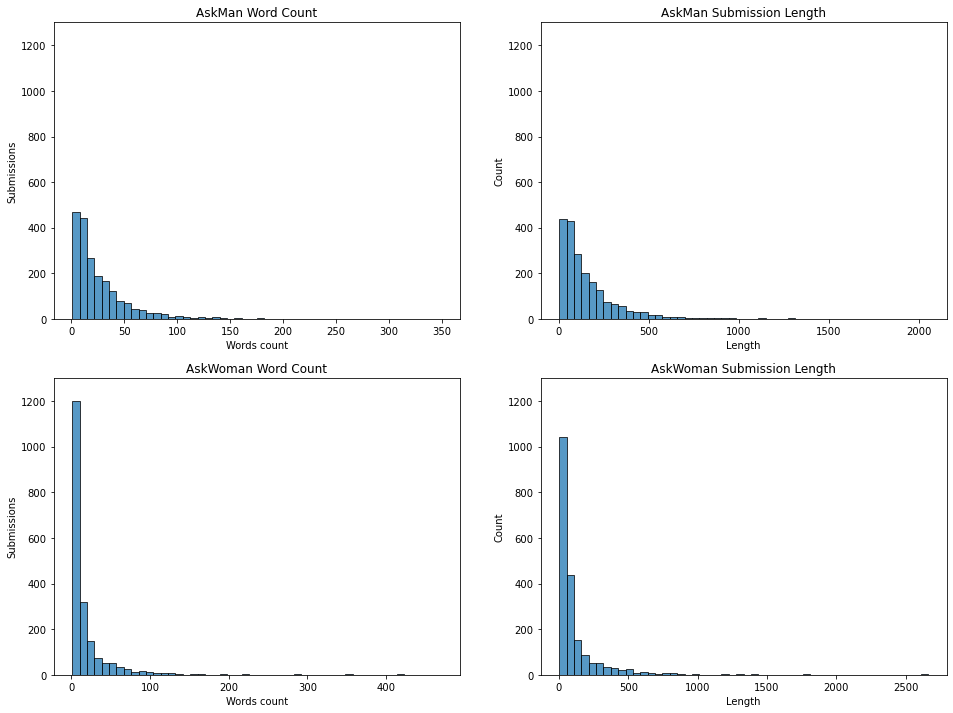

In [1898]:
plt.tight_layout()

plt.subplots_adjust(hspace=.2)
plt.figure(figsize=(16,12))
plt.subplot(2, 2, 1)
#AskMan Word Count
plt.title('AskMan Word Count')
sns.histplot(df[df["sex"]==1]['sub_word_count'],bins=50,)
plt.ylim(0, 1300)
plt.xlabel('Words count')
plt.ylabel('Submissions')
#AskMan Submission Length
plt.subplot(2, 2, 2)
plt.title('AskMan Submission Length')
sns.histplot(df[df["sex"]==1]['sub_length'],bins=50)
plt.ylim(0, 1300)
plt.xlabel('Length')
plt.ylabel('Count')
#AskWoman Word Count
plt.subplot(2, 2, 3)
plt.title('AskWoman Word Count')
sns.histplot(df[df["sex"]==0]['sub_word_count'],bins=50,)
plt.ylim(0, 1300)
plt.xlabel('Words count')
plt.ylabel('Submissions')
#AskWoman Submission Length
plt.subplot(2, 2, 4)
plt.title('AskWoman Submission Length')
sns.histplot(df[df["sex"]==0]['sub_length'],bins=50)
plt.ylim(0, 1300)
plt.xlabel('Length')
plt.ylabel('Count')

plt.savefig('../resources/Distribution_submissions.png')
plt.show()

##### Summary

Word count statisticks

In [1899]:
print(df[df["sex"]==1]['sub_word_count'].describe())
df[df["sex"]==0]['sub_word_count'].describe()

count    2044.000000
mean       27.636497
std        32.114279
min         1.000000
25%         8.000000
50%        17.000000
75%        35.250000
max       349.000000
Name: sub_word_count, dtype: float64


count    2005.000000
mean       20.024439
std        36.700668
min         1.000000
25%         5.000000
50%         8.000000
75%        19.000000
max       470.000000
Name: sub_word_count, dtype: float64

Submission length statisticks

In [1900]:
df[df["sex"]==1]['sub_length'].describe(),df[df["sex"]==0]['sub_length'].describe()

(count    2044.000000
 mean      165.909980
 std       193.793987
 min         2.000000
 25%        48.000000
 50%       103.500000
 75%       213.000000
 max      2052.000000
 Name: sub_length, dtype: float64,
 count    2005.000000
 mean      121.145636
 std       217.865067
 min         1.000000
 25%        30.000000
 50%        52.000000
 75%       117.000000
 max      2660.000000
 Name: sub_length, dtype: float64)

Heatmap

<AxesSubplot:>

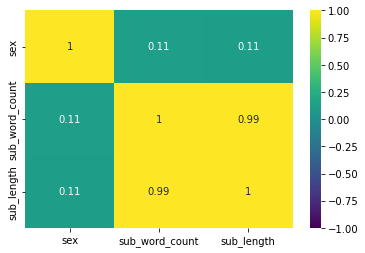

In [1901]:
sns.heatmap(df.corr(),annot=True, vmin=-1,vmax=1,cmap="viridis")

No noticable correaltions.

Pairplot

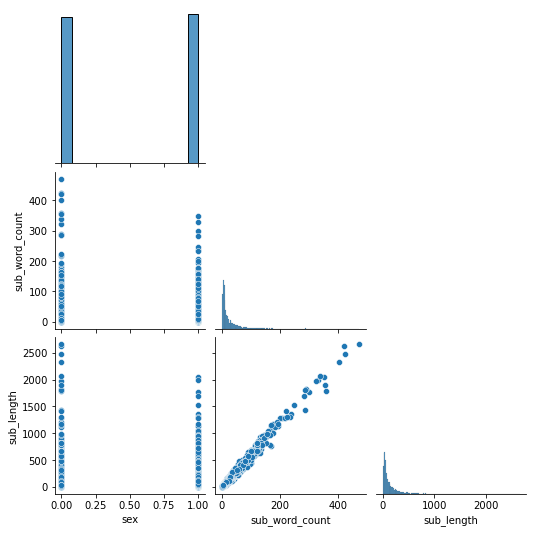

In [1902]:
sns.pairplot(df,corner=True)

In [1903]:

def bigrams_clean(list_f):
    try:
       for x in list_f:
         if x=="":
          return "np.NAN"
         elif x==" ":   
            return "np.NAN"
         else:

            return list_f
          
    except:
       p=1


In [1904]:
bigram_freq = lambda s: list(nltk.FreqDist(nltk.bigrams(s.strip().split(" "))).items())

out = df['comment'].apply(bigram_freq).explode()


out = pd.DataFrame(out.to_list(), index=out.index, columns=["submissions", "bigrams"])
#bigram made some mistakes, so I had to make cleaning
for x,k in enumerate(out.iloc[:,0]):
    try:
        if k[0]=="":
            out.iloc[x,0]=np.nan
        if k[1]=="":
            out.iloc[x,0]=np.nan
    except:
        p=1
out=out.dropna()
bigram_count=out["submissions"].value_counts().head(20)

331
3269
3799
4732
4805
6682
6761
7667
7807
8551
10882
13201
14977
15276
15945
16869
17328
17605
18945
19898
20919
21436
21864
24912
25619
26634
26655
27939
28496
29907
29919
31489
33269
33792
36093
39223
39800
41190
41490
42997
43562
43763
44562
45878
46412
52701
52745
53363
54239
55480
55917
56570
58125
58816
59029
59520
60601
60954
61858
63411
63412
64027
64809
66229
66662
66785
66788
67212
67396
67588
67874
67977
68013
68063
68945
70946
70963
71019
72132
73968
74407
74447
74534
74535
75048
75127
76214
77483
78139
78425
79020
79188
79237
79238
79333
79527
80651
81379
83518
83527
83538
83839
84784
85071
85072
85474
85879
86020
87556


Plotting a bar graph of the most frequnt bigrams


/Users/glebradchenko/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<Figure size 432x288 with 0 Axes>

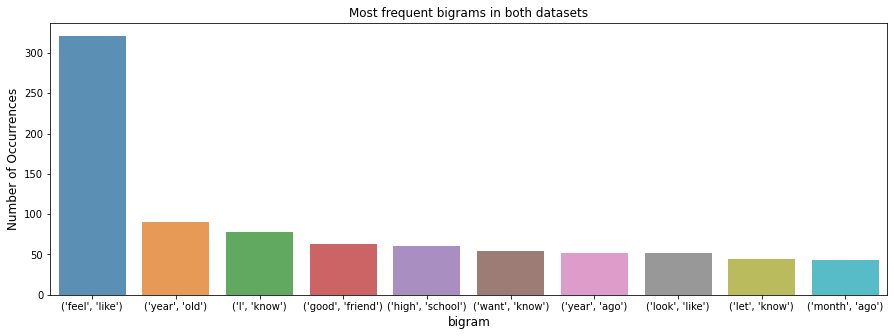

<Figure size 432x288 with 0 Axes>

In [1909]:
# Plotting a bar graph of the most frequnt bigrams
plt.tight_layout()
bigram_count = bigram_count[:10,]
plt.figure(figsize=(15,5))
sns.barplot(bigram_count.index, bigram_count.values, alpha=0.8)
plt.title('Most frequent bigrams in both datasets')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('bigram', fontsize=12)
plt.show();
plt.savefig('../resources/bigrams.png')

In [1911]:
bigram_freq = lambda s: list(nltk.FreqDist(nltk.trigrams(s.split(" "))).items())

out = df['comment'].apply(bigram_freq).explode()
out = pd.DataFrame(out.to_list(), index=out.index, columns=["submissions", "bigrams"])
for x,k in enumerate(out.iloc[:,0]):
    try:
        if k[0]=="":
            out.iloc[x,0]=np.nan
        if k[1]=="":
            out.iloc[x,0]=np.nan
        if k[2]=="":
            out.iloc[x,0]=np.nan
    except:
        p=1
out=out.dropna()
trigram_count=out["submissions"].value_counts().head(20)

/Users/glebradchenko/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<Figure size 432x288 with 0 Axes>

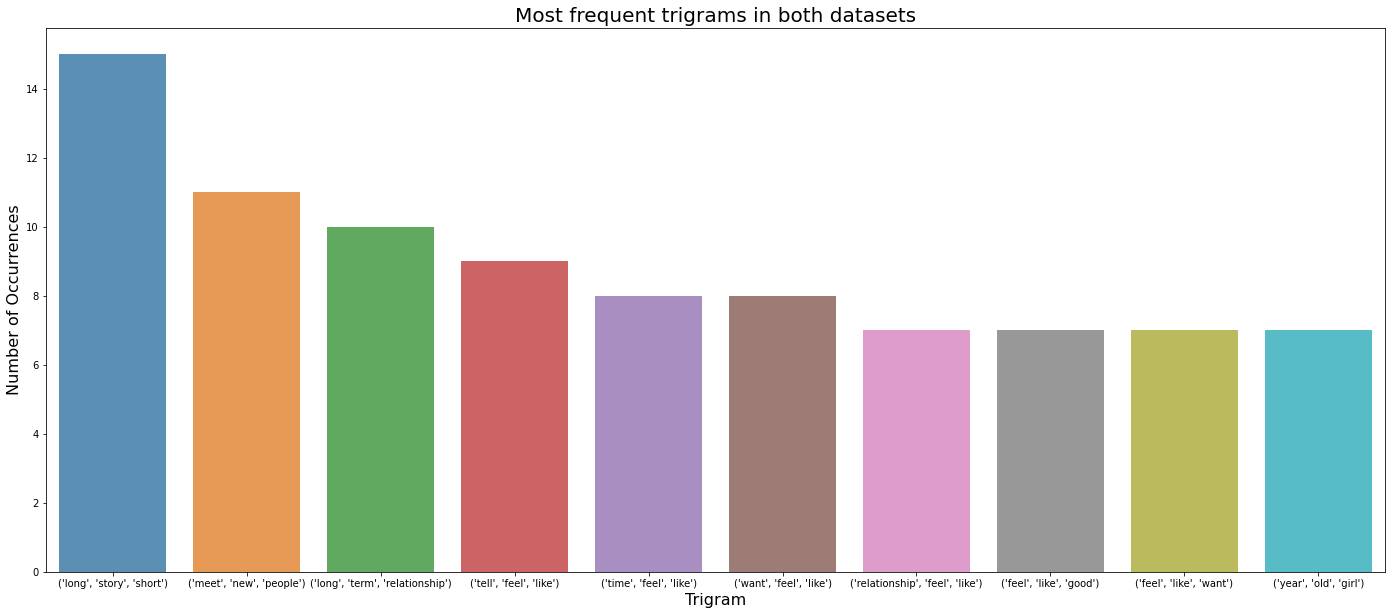

<Figure size 432x288 with 0 Axes>

In [1925]:
# Plotting a bar graph of the most frequnt bigrams
plt.tight_layout()
trigram_count = trigram_count[:10,]
plt.figure(figsize=(24,10))
sns.barplot(trigram_count.index, trigram_count.values, alpha=0.8)
plt.title('Most frequent trigrams in both datasets',fontsize=20)
plt.ylabel('Number of Occurrences', fontsize=16)
plt.xlabel('Trigram', fontsize=16)
plt.xticks(fontsize=10)
plt.show();
plt.savefig('../resources/trigrams.png')

# Tokenization

In [1462]:
def get_tokens(docs):
    df_tokens = []
    for x in docs:
        man=nlp(x)
        for token in man:
            t_dict = {
            'text': token,
            'POS': token.pos_,
            'POS explained': spacy.explain(token.pos_),        
            'lemma': token.lemma_
            }
            df_tokens.append(t_dict)
        
    return pd.DataFrame(df_tokens)

In [1515]:
docs_man = list(nlp.pipe(df[df['sex']==1]["comment"]))
docs_woman = list(nlp.pipe(df[df['sex']==0]["comment"]))

In [1516]:
df_man_tokens=get_tokens(docs_man)
df_woman_tokens=get_tokens(docs_woman)


In [1517]:
df_man_tokens.shape

(55611, 4)

In [1518]:
df_man_tokens[df_man_tokens["POS"]=="AUX"].shape

(279, 4)

In [1519]:
df_man_tokens=get_tokens(docs_man)
df_woman_tokens=get_tokens(docs_woman)


In [1520]:
df_man_tokens.reset_index(inplace=True)
df_man_tokens.drop(columns='index',inplace=True)

In [1521]:
df_man_tokens

,text,POS,POS explained,lemma
0,happen,VERB,verb,happen
1,today,NOUN,noun,today
2,tell,VERB,verb,tell
3,friend,NOUN,noun,friend
4,talk,NOUN,noun,talk
...,...,...,...,...
55606,nice,ADJ,adjective,nice
55607,guy,NOUN,noun,guy
55608,ghost,NOUN,noun,ghost
55609,wonder,NOUN,noun,wonder


<AxesSubplot:>

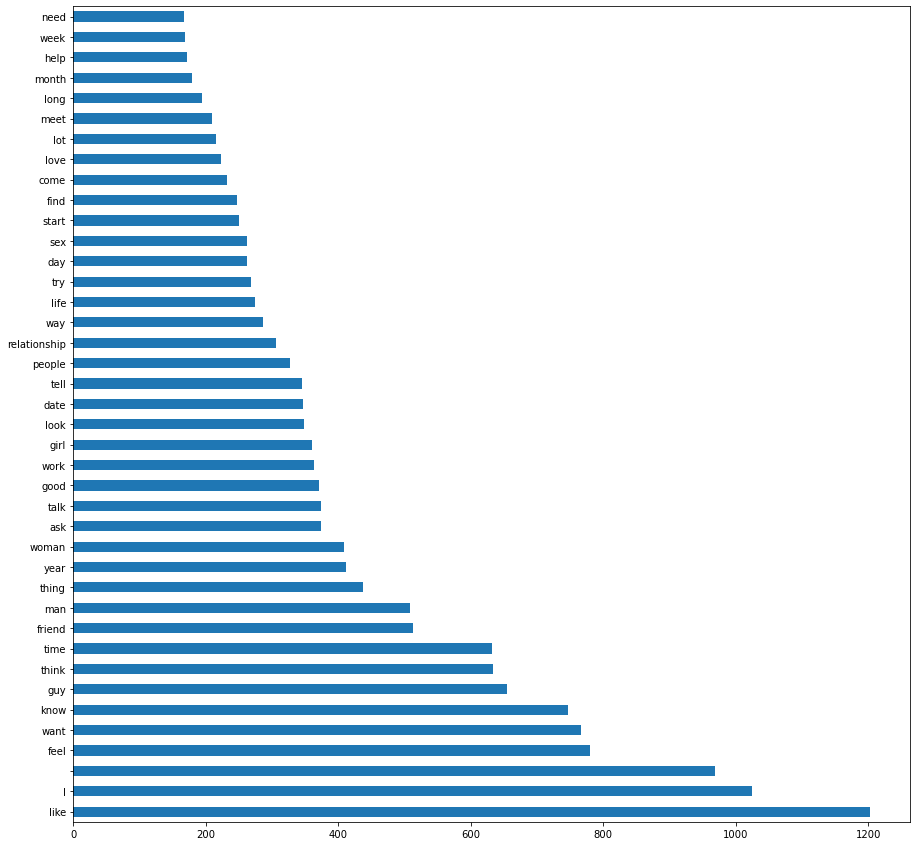

In [1522]:
plt.figure(figsize=(15,15))
df_man_tokens["lemma"].value_counts().sort_values(ascending=False).head(40).plot(kind="barh")

### Now let's look at the most popular words in the AskWoman section

In [1523]:
df_woman_tokens[df_woman_tokens["POS"]=="AUX"].sample(10)

,text,POS,POS explained,lemma
33036,try,AUX,auxiliary,try
39733,let,AUX,auxiliary,let
23296,know,AUX,auxiliary,know
37039,need,AUX,auxiliary,need
1010,try,AUX,auxiliary,try
20234,want,AUX,auxiliary,want
36619,try,AUX,auxiliary,try
20226,let,AUX,auxiliary,let
14555,let,AUX,auxiliary,let
2533,try,AUX,auxiliary,try


<AxesSubplot:>

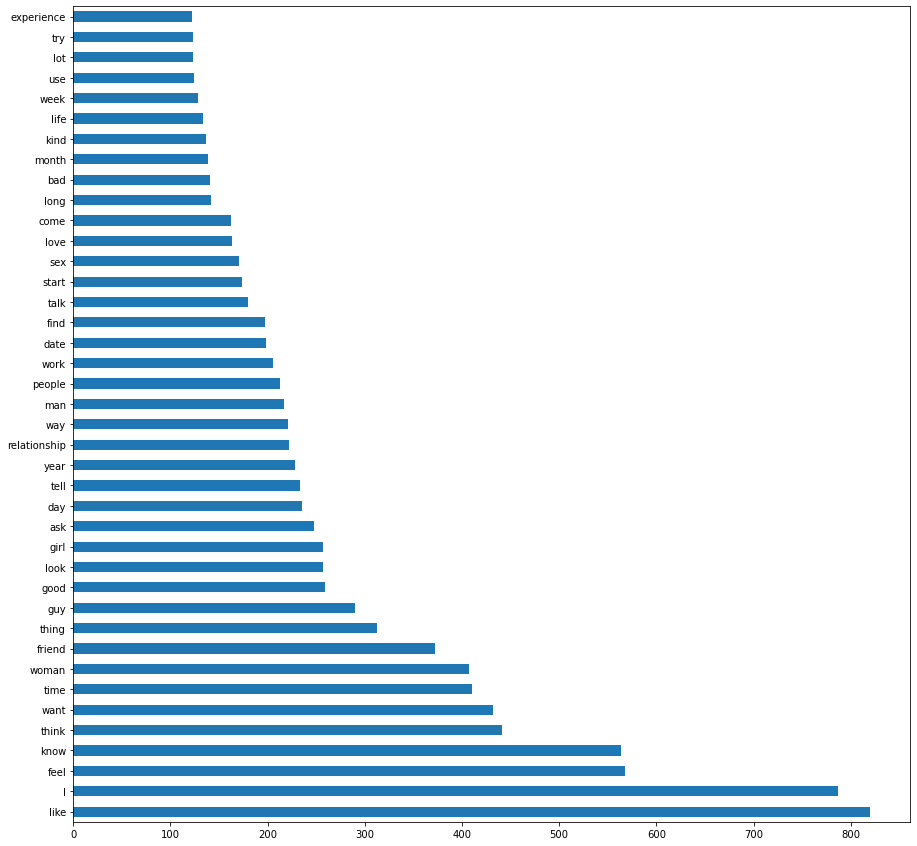

In [1524]:
df_woman_tokens=df_woman_tokens[df_woman_tokens["POS"]!="AUX"]
df_woman_tokens=df_woman_tokens[df_woman_tokens["POS"]!="SPACE"]
# df_woman_tokens=df_woman_tokens[df_woman_tokens["POS"]!="PROPN"]
df_woman_tokens.reset_index(inplace=True)
df_woman_tokens.drop(columns='index',inplace=True)
plt.figure(figsize=(15,15))
df_woman_tokens["lemma"].value_counts().sort_values(ascending=False).head(40).plot(kind="barh")

Almost all of most frequent words are Stopwords. 

### Removing StopWords


In [1525]:
print(df_man_tokens.shape[0])
df_man_tokens_stopwords=df_man_tokens[~df_man_tokens['lemma'].isin(nlp.Defaults.stop_words)]
print(df_man_tokens_stopwords.shape[0])
df_man_tokens_stopwords=df_man_tokens_stopwords[~df_man_tokens_stopwords['lemma'].isin(stopwords.words('english'))]
print(df_man_tokens_stopwords.shape[0])


55611
55592
55592


In [1526]:
print(df_woman_tokens.shape[0])
df_woman_tokens_stopwords=df_woman_tokens[~df_woman_tokens['lemma'].isin(nlp.Defaults.stop_words)]
print(df_woman_tokens_stopwords.shape[0])
df_woman_tokens_stopwords=df_woman_tokens_stopwords[~df_woman_tokens_stopwords['lemma'].isin(stopwords.words('english'))]
print(df_woman_tokens_stopwords.shape[0])

38825
38817
38817


<AxesSubplot:>

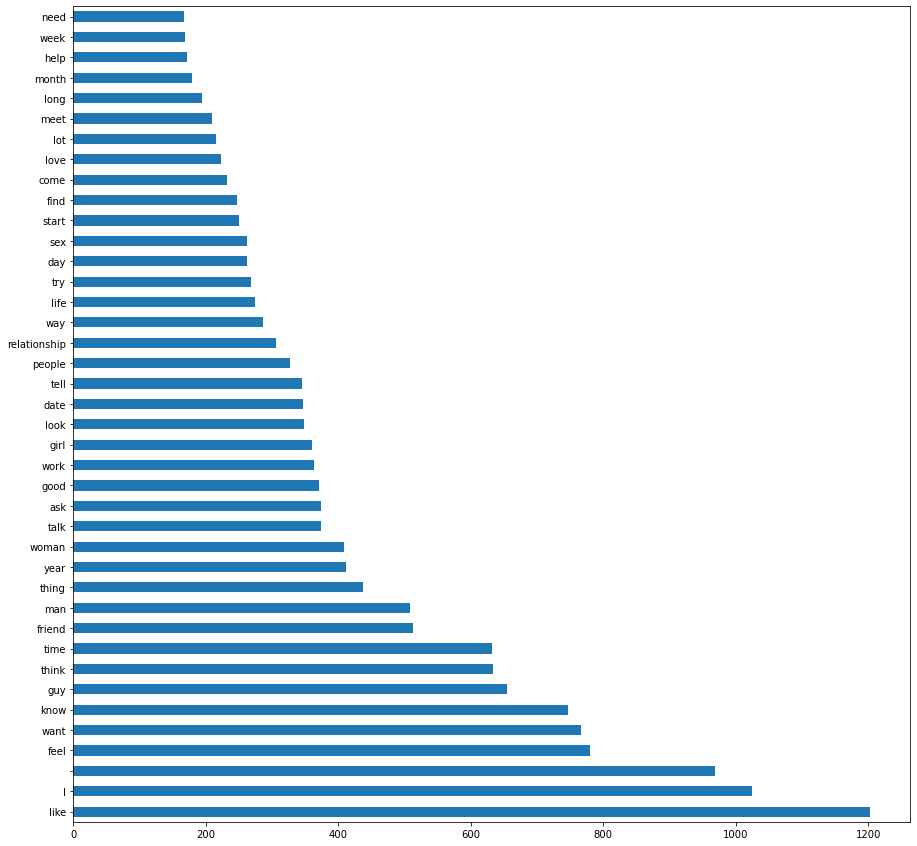

In [1527]:
plt.figure(figsize=(15,15))
df_man_tokens_stopwords["lemma"].value_counts().sort_values(ascending=False).head(40).plot(kind="barh")

<AxesSubplot:>

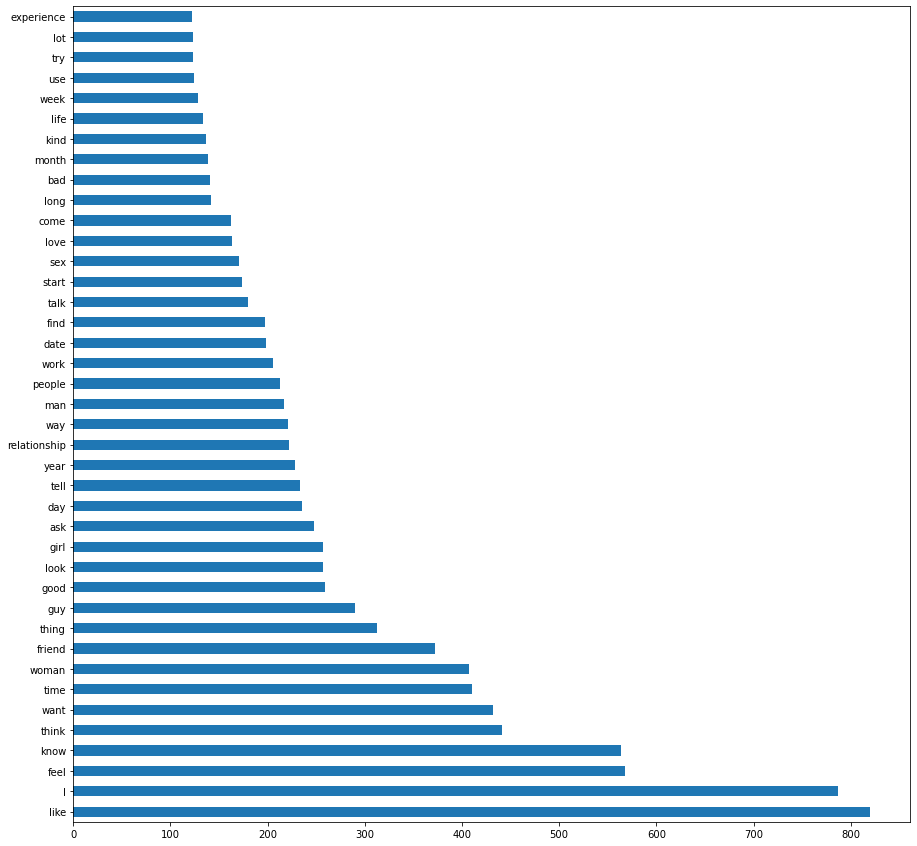

In [1528]:
plt.figure(figsize=(15,15))
df_woman_tokens_stopwords["lemma"].value_counts().sort_values(ascending=False).head(40).plot(kind="barh")

In [1529]:
print(df_man_tokens_stopwords.shape[0])
len(set(df_man_tokens_stopwords["lemma"]))

55592


5872

In [1530]:
print(df_woman_tokens_stopwords.shape[0])
len(set(df_woman_tokens_stopwords["lemma"]))
 

38817


5142

In [1531]:
df_woman_tokens_stopwords.reset_index(inplace=True)
df_woman_tokens_stopwords.drop(columns='index',inplace=True)
df_man_tokens_stopwords.reset_index(inplace=True)
df_man_tokens_stopwords.drop(columns='index',inplace=True)
df_woman_tokens_stopwords



,text,POS,POS explained,lemma
0,I,PRON,pronoun,I
1,find,VERB,verb,find
2,trouble,NOUN,noun,trouble
3,miss,VERB,verb,miss
4,ex,PROPN,proper noun,ex
...,...,...,...,...
38812,suggestion,NOUN,noun,suggestion
38813,story,NOUN,noun,story
38814,girl,NOUN,noun,girl
38815,girl,NOUN,noun,girl


In [1532]:
df_woman_tokens_stopwords

,text,POS,POS explained,lemma
0,I,PRON,pronoun,I
1,find,VERB,verb,find
2,trouble,NOUN,noun,trouble
3,miss,VERB,verb,miss
4,ex,PROPN,proper noun,ex
...,...,...,...,...
38812,suggestion,NOUN,noun,suggestion
38813,story,NOUN,noun,story
38814,girl,NOUN,noun,girl
38815,girl,NOUN,noun,girl


In [1533]:
modeling_set_2_w=df_woman_tokens_stopwords[["lemma"]]
modeling_set_2_m=df_man_tokens_stopwords[["lemma"]]
modeling_set_2_w["sex"]=0
modeling_set_2_m['sex']=1
modeling_set_2=pd.concat([modeling_set_2_w,modeling_set_2_m]);
modeling_set_2.reset_index(inplace=True,drop=True)
modeling_set_2

/Users/glebradchenko/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/glebradchenko/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,lemma,sex
0,I,0
1,find,0
2,trouble,0
3,miss,0
4,ex,0
...,...,...
94404,nice,1
94405,guy,1
94406,ghost,1
94407,wonder,1


In [1534]:
modeling_set_2.to_csv('../data/df_submissions_2nd.csv',index=False)

In [1535]:
df_man_tokens_stopwords_uniq=df_man_tokens_stopwords.drop_duplicates('lemma')
df_woman_tokens_stopwords_uniq=df_woman_tokens_stopwords.drop_duplicates('lemma')

In [1536]:
df_man_tokens_stopwords_uniq

,text,POS,POS explained,lemma
0,happen,VERB,verb,happen
1,today,NOUN,noun,today
2,tell,VERB,verb,tell
3,friend,NOUN,noun,friend
4,talk,NOUN,noun,talk
...,...,...,...,...
55561,verse,NOUN,noun,verse
55571,cuff,NOUN,noun,cuff
55573,pullin,VERB,verb,pullin
55574,spank,NOUN,noun,spank
